<a href="https://colab.research.google.com/github/CamilleGreen5/Deep_Learning_with_Python/blob/master/Noise_speech_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO :
- methode des masks donnent mauvais résultats (avec label)

## **DATA LOADING**

In [ ]:
# !pip install pydub

In [ ]:
# !wget https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-5.1-2020-06-22/fr.tar.gz
# !tar -xf fr.tar.gz

In [ ]:
# creating folders

!rm fr.tar.gz
!rm -r sample_data

!mkdir sons
!mkdir sons/original
!mkdir sons/noisy
!mkdir sons/denoised

!mkdir data
!mkdir data/train_data
!mkdir data/val_data
!mkdir data/test_data
!mkdir data/train_data/folder1
!mkdir data/val_data/folder1
!mkdir data/test_data/folder1

!cp cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_18157595.mp3 ./sons/original

## **FUNCTIONS AND LIBRARIES LOAD**

In [ ]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import os
import cv2 as cv
from scipy.io.wavfile import read, write
from scipy.signal import stft, istft
from pydub import AudioSegment
from tensorflow.keras import models, layers
from tqdm.notebook import tqdm

## **DATA CONVERSION**

In [ ]:
def add_noise(array_sound):
    """
    function to add gaussian noise to an array
    -- array_sound : array which to add noise
    -- return : the noisy array
    """
    max_1 = np.max(array_sound)
    noise = np.random.normal(0, 0.02*max_1, len(array_sound))
    array_sound_noisy = np.add(noise, array_sound)
    max_2 = np.max(array_sound_noisy)
    array_sound_noisy = (array_sound_noisy*max_1)//max_2

    return np.array(array_sound_noisy, np.int16)

In [ ]:
def load_and_convert_data_with_label(train_mp3_data, mode='train'):
    """
    function to load data, convert them to array and save as image.
    sample and label, are concanated to be saved as one image
    -- train_mp3_data : list of mp3 data to convert
    -- mode : train/val/test to indicate where to save images
    """
    i = 0

    for path_to_mp3_file in tqdm(train_mp3_data):

        # load mp3 sound to array
        loaded_sound = AudioSegment.from_mp3(path_to_mp3_file)
        array_sound = np.array(loaded_sound.get_array_of_samples(), np.int16)
        # print(np.max(np.max(array_sound)))
        
        # normalize array
        mean = np.mean(array_sound, axis=0)
        array_sound -= int(mean)

        # convert label to to F_T_space
        f, t, array_stft = stft(array_sound, fs=48000, nperseg=1000)
        original_abs_stft = np.abs(array_stft[:,:1000])

        # padding
        pad_length = 1000 - np.shape(original_abs_stft)[1]
        # print(pad_length)
        original_abs_stft = np.pad(original_abs_stft, ((0,0), (0, pad_length)))
        # print(np.shape(original_abs_stft))
        
        # add random noise
        array_sound_noisy = add_noise(array_sound)

        # plot original and noisy
        # plt.plot([i for i in range(len(array_sound_noisy))], array_sound_noisy, 'r')
        # plt.plot([i for i in range(len(array_sound))], array_sound, 'b')
        # plt.show()

        # save noisy sound to wav
        # path_to_wav_file = './sons/noisy/noisy_sound0.wav'
        # write(path_to_wav_file, 48000, array_sound_noisy)

        # convert sample to to F_T_space
        f, t, array_stft = stft(array_sound_noisy, fs=48000, nperseg=1000)
        sample_abs_stft = np.abs(array_stft[:,:1000])

        # padding 
        pad_length = 1000 - np.shape(sample_abs_stft)[1]
        sample_abs_stft = np.pad(sample_abs_stft, ((0,0), (0, pad_length)))
        # print(np.shape(sample_abs_stft))

        # convertion to image format
        sample_to_save = sample_abs_stft//(np.max(np.max(sample_abs_stft))/32767)
        label_to_save = original_abs_stft//(np.max(np.max(original_abs_stft))/32767)
        sample_to_save0 = sample_to_save - sample_to_save%1000
        sample_to_save1 = sample_to_save - sample_to_save0 - sample_to_save%10
        label_to_save0 = label_to_save - label_to_save%1000
        label_to_save1 = label_to_save - label_to_save0 - label_to_save%10
        sample_label_to_save = np.stack((sample_to_save0, sample_to_save1, label_to_save0, label_to_save1), axis=2)
        sample_label_to_save = np.array(sample_label_to_save, np.int16)
        # print(np.shape(sample_label_to_save))

        # saving images
        if mode == 'train':
            path_sample = str("./data/train_data/folder1/sample" + str(i) + ".png")
        elif mode == 'val':
            path_sample = str("./data/val_data/folder1/sample" + str(i) + ".png")
        elif mode == 'test':
            path_sample = str("./data/test_data/folder1/sample" + str(i) + ".png")
        else:
            print("chose a mode")
        tf.keras.preprocessing.image.save_img(path_sample, sample_label_to_save, data_format='channels_last')

        # free space
        path = train_mp3_data[i]
        try:
            os.remove(path)
        except FileNotFoundError:
            continue

        i+=1
    

In [ ]:
# !rm data/test_data/folder1/*
# !rm data/train_data/folder1/*
# !rm data/val_data/folder1/*

In [ ]:
list_mp3_files = glob.glob("./cv-corpus-5.1-2020-06-22/fr/clips/*.mp3")
print(len(list_mp3_files))

train_mp3_data = list_mp3_files[:2]
# val_mp3_data = list_mp3_files[1000:1250]
# test_mp3_data = list_mp3_files[7000:14000]

In [ ]:
load_and_convert_data_with_label(train_mp3_data, 'train')
# load_and_convert_data_with_label(val_mp3_data, 'val')
# load_and_convert_data_with_label(test_mp3_data, 'test')

In [ ]:
!ls data/train_data/folder1 | wc -l

## **MODEL FITING**

In [ ]:
# !rm -r logs/fit/*

In [ ]:
def build_model():
    """
    function to build the model
    -- return the compiled model
    """
    model = models.Sequential()
    model.add(layers.SeparableConv2D(16, (3, 3), activation='relu', padding='same', input_shape=(1000, 501, 1)))
    model.add(layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.SeparableConv2D(1, (3, 3), activation='relu', padding='same'))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model

In [ ]:
def data_generator(mode='train', batch_size=5):
    """
    generator to load image and convert to array of sample and label on the fly
    -- mode : train/val/test indicate where to load data
    -- batch_size : size of the batch to return
    -- return : batch of sample and label
    """
    img_gen = tf.keras.preprocessing.image.ImageDataGenerator()
    if mode == 'train':
        samples_and_labels = img_gen.flow_from_directory("./data/train_data/", class_mode=None, target_size=(501, 1000), batch_size=1, color_mode='rgba')
    elif mode == 'val':
        samples_and_labels = img_gen.flow_from_directory("./data/val_data/", class_mode=None, target_size=(501, 1000), batch_size=1, color_mode='rgba')
    elif mode == 'test':
        samples_and_labels = img_gen.flow_from_directory("./data/test_data/", class_mode=None, target_size=(501, 1000), batch_size=1, color_mode='rgba')  
    else:
        print("chose a mode")

    batch_sample = []
    batch_label = []

    for sample_and_label in samples_and_labels:
        sample_and_label = np.array(sample_and_label, np.int16)
        # print(np.shape(sample_and_label))
        sample0 = np.squeeze(sample_and_label[:,:,:,0])
        sample1 = np.squeeze(sample_and_label[:,:,:,1])
        label0 = np.squeeze(sample_and_label[:,:,:,2])
        label1 = np.squeeze(sample_and_label[:,:,:,3])
        sample = 1000*sample0 + 10*sample1
        label = 1000*label0 + 10*label1
        max_arr = 32767
        sample = np.array(sample/max_arr, np.float32)
        label = np.array(label/max_arr, np.float32)

        sample = tf.convert_to_tensor(sample)
        label = tf.convert_to_tensor(label)

        sample = np.transpose(sample)
        label = np.transpose(label)

        # print(np.shape(sample))
        # print(np.shape(label))

        if len(batch_sample) == batch_size:
            yield batch_sample, batch_label
            batch_sample = []
            batch_label = []
        else:
            batch_sample.append(sample)
            batch_label.append(label)
        
def create_train_generator():
    gen = data_generator('train')
    return gen
        
def create_val_generator():
    gen = data_generator('val')
    return gen

In [ ]:
# Load model, create generator, fit the model and save it to 'model' folder

NEW_MODEL = True
if NEW_MODEL:
    !rm -r logs/fit/*

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

if NEW_MODEL:
    model = build_model()
else:
    model = tf.keras.models.load_model("model/mymodel")


train_dataset = tf.data.Dataset.from_generator(create_train_generator, output_types=(tf.float32, tf.float32), output_shapes=((5, 1000, 501), (5, 1000, 501)))
validation_dataset = tf.data.Dataset.from_generator(create_val_generator, output_types=(tf.float32, tf.float32), output_shapes=((5, 1000, 501), (5, 1000, 501)))

model.fit(train_dataset, epochs=50, shuffle=True, callbacks=[tensorboard_callback],\
          steps_per_epoch=1000, validation_data=validation_dataset, validation_steps=250, verbose=1)

model.save('./model/mymodel')
print('model saved')


In [ ]:
model.save('./model/mymodel')
print('model saved')

## **VISUALISATION**


In [ ]:
# !kill 8599

In [ ]:
%tensorboard --logdir logs/fit --host localhost

 ## **AUDIO RECONVERSION**

In [ ]:
def load_and_convert_data(train_mp3_data, add_noise_to_sample=False):
    """
    function to load mp3 data, only the sample, and convert it to array, then to f-t-domain
    -- train_mp3_data : list of mp3 data to load
    -- add_noise_to_sample : True/False indicate if noise has to be added
    -- return : abs and im part of the sample, some characteristic of the sample
    """
    samples = []
    im_samples = []
    i = 0

    for path_to_mp3_file in tqdm(train_mp3_data):

        # load mp3 sound to array
        loaded_sound = AudioSegment.from_mp3(path_to_mp3_file)
        array_sound = np.array(loaded_sound.get_array_of_samples(), np.float64)

        len_arr = len(array_sound)

        plt.plot([i for i in range(len(array_sound))], array_sound, 'b')
        plt.show()

        # normalize array
        mean = np.mean(array_sound, axis=0)
        array_sound -= mean

        if add_noise_to_sample:
            array_sound = add_noise(array_sound)
            # save reconverted sound to wav
            path_to_wav_file = './sons/noisy/noisy_sound0.wav'
            write(path_to_wav_file, 48000, array_sound)

        max_arr = np.max(np.abs(array_sound))
        array_sound = np.array(array_sound/max_arr, np.float32)

        # convert sample to to F_T_space
        f, t, array_stft = stft(array_sound, fs=48000, nperseg=1000)
        sample_abs_stft = np.abs(array_stft)
        sample_im_stft = np.imag(array_stft)

        # padding 
        pad_length = 1000 - np.shape(sample_abs_stft)[1]
        sample_abs_stft = np.pad(sample_abs_stft, ((0,0), (0, pad_length)))
        sample_im_stft = np.pad(sample_im_stft, ((0,0), (0, pad_length)))

        samples.append(sample_abs_stft)
        im_samples.append(sample_im_stft)
        i+=1

    samples = np.array(samples)
    im_samples = np.array(im_samples)

    return samples, im_samples, mean, max_arr, len_arr

In [ ]:
def denoising(samples, imag_samples, mean, max_arr, len_arr):
    """
    function to denoise data by loading the model, predict and convert back to array of sound
    -- samples : sample to denoise
    -- imag_samples : im part of the sample to denoise
    -- some characteristics of the sample
    -- return : the denoised array
    """
    # load model
    model = tf.keras.models.load_model('./model/mymodel')

    # reshape data
    samples = np.squeeze(samples)
    imag_samples = np.squeeze(imag_samples)
    samples = np.transpose(samples)
    imag_samples = np.transpose(imag_samples)
    samples = np.expand_dims(samples, axis=0)
    imag_samples = np.expand_dims(imag_samples, axis=0)
    # print(np.shape(samples))

    # predict
    denoised_samples = model.predict(samples)

    denoised_samples = np.transpose(denoised_samples)
    imag_samples = np.transpose(imag_samples)

    # print(np.shape(denoised_samples))

    # plt.pcolormesh(denoised_samples[:len_arr,:])
    # plt.title('STFT denoised Magnitude')
    # plt.ylabel('Frequency [Hz]')
    # plt.xlabel('Time [sec]')
    # plt.show()

    denoised_stft = denoised_samples + 1j*imag_samples
    denoised_stft = np.squeeze(denoised_stft)
    print(np.shape(denoised_stft))

    # convert back to sound from F_T_space
    t, desnoised_array_sound = istft(denoised_stft, fs=48000, nperseg=1000)
    desnoised_array_sound = np.array(desnoised_array_sound)
    desnoised_array_sound *= max_arr
    desnoised_array_sound += mean
    desnoised_array_sound = np.array(desnoised_array_sound, np.int16)

    return desnoised_array_sound


In [ ]:
# load a mp3 file, convert it to array and then to f-t-domain, add noise, predict the denoised array and save it

list_files = ["./sons/original/common_voice_fr_18157595.mp3"]
samples, imag_samples, mean, max_arr, len_arr = load_and_convert_data(list_files, True)

denoised_array_sound = denoising(samples, imag_samples, mean, max_arr, len_arr)
# print(len_arr)
denoised_array_sound = denoised_array_sound[:len_arr]
print(np.shape(denoised_array_sound))

plt.plot([i/48000 for i in range(len_arr)], denoised_array_sound, 'r')
plt.show()

# print(np.shape(denoi sed_samples))
samples, x = reshape_data(samples)
samples = np.transpose(samples)
samples = samples[:len_arr,:]

# print(np.shape(samples))
# print(np.shape(denoised_array_sound))

# plt.pcolormesh(samples)
# plt.title('STFT sample Magnitude')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

# save reconverted sound to wav
path_to_wav_file = './sons/denoised/denoised_sound0.wav'
write(path_to_wav_file, 48000, denoised_array_sound)
    

In [ ]:
!ls model/mymodel/assets

## **TEST**

In [ ]:
# load mp3 sound to array
mp3_sound = AudioSegment.from_mp3("./sons/original/common_voice_fr_18157595.mp3")
array_sound_mp3 = np.array(mp3_sound.get_array_of_samples())

# save original to wav
path_to_wav_file = './sons/noised/noised_sound0.wav'
write(path_to_wav_file, 48000, array_sound_mp3)

# save to mp3 from wav
mp3_sound_save = AudioSegment.from_wav(path_to_wav_file)
mp3_sound_save.export('./sons/original/noised_sound0.mp3', format='mp3')

# load wav sound to array
samplerate, wav_sound = read("./sons/noised/noised_sound0.wav")
array_sound_wav = np.array(wav_sound, np.float64)

# # plot
# plt.plot([i for i  in range(len(array_sound_wav))], array_sound_wav, 'b')
# plt.show()
# plt.plot([i for i  in range(len(array_sound_mp3))], array_sound_mp3, 'r')
# plt.show()


FileNotFoundError: ignored

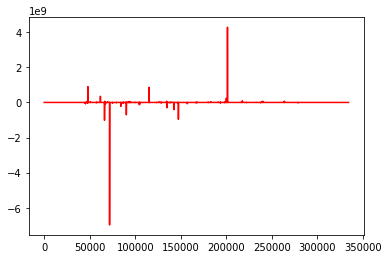

In [ ]:
for i, path_to_mp3_file in enumerate(list_mp3_files[1:2]):

    # load mp3 sound to array
    loaded_sound = AudioSegment.from_mp3(path_to_mp3_file)
    array_sound = np.array(loaded_sound.get_array_of_samples(), np.float64)

    # normalize array
    mean = np.mean(array_sound, axis=0)
    std = np.std(array_sound)
    array_sound -= mean
    array_sound /= std

    # add random noise
    max_1 = max(array_sound)
    noise = np.random.normal(0, 0.75, len(array_sound))
    array_sound_noisy = np.add(noise, array_sound)
    max_2 = max(array_sound_noisy)
    array_sound_noisy *= max_1/max_2
    
    # # save original to wav
    # array_sound_noisy_to_save = array_sound_noisy * std
    # array_sound_noisy_to_save += mean
    # array_sound_noisy_to_save = np.array(array_sound_noisy_to_save, np.int16)
    # path_to_wav_file = './noised/noised_sound0.wav'
    # write(path_to_wav_file, 48000, array_sound_noisy_to_save)

    # denoised = np.where(np.sqrt(array_sound_noisy**2-array_sound**2)>array_sound_noisy/3, 0, array_sound_noisy)
    # mask = np.where(0<=(array_sound**2)/(noise**2),(array_sound**2)/(noise**2), 0)
    # mask = np.where(mask<1,mask, 1)
    mask = (array_sound**2)/(noise**2)

    denoised = array_sound_noisy * mask

    # plot original and noisy
    # plt.plot([i for i  in range(len(noise))], noise, 'r')
    # plt.plot([i for i  in range(len(array_sound))], array_sound, 'b')
    # plt.plot([50000+i for i  in range(1000)], mask[50000:51000], 'r')
    plt.plot([i for i  in range(len(denoised))], denoised, 'r')
    plt.show()

    # save reconverted sound to wav
    path_to_wav_file = './denoised/denoised_sound0.wav'
    write(path_to_wav_file, 48000, denoised)

    # # convert sound to to F_T_space
    # f, t, array_stft = stft(array_sound_noisy, fs=48000, nperseg=1000)
    # array_abs_stft = np.abs(array_stft)

    # plt.pcolormesh(t, f, array_abs_stft)
    # plt.title('STFT Magnitude')
    # plt.ylabel('Frequency [Hz]')
    # plt.xlabel('Time [sec]')
    # plt.show()

    # # convert back to sound from F_T_space
    # t, desnoised_array_sound = istft(array_stft, fs=48000, nperseg=1000)
    # desnoised_array_sound = np.array(desnoised_array_sound)
    # desnoised_array_sound *= std
    # desnoised_array_sound += mean
    # desnoised_array_sound = np.array(desnoised_array_sound, np.int16)

    # # save reconverted sound to wav
    # path_to_wav_file = './denoised/denoised_sound' + str(i) + '.wav'
    # write(path_to_wav_file, 48000, desnoised_array_sound)
    

In [ ]:
for path_to_mp3_file in tqdm(train_mp3_data):
    # print(i)
    a =1



100%|██████████| 500/500 [00:00<00:00, 310643.16it/s]


In [ ]:

samples, labels, mean, std = load_and_convert_data_with_label(list_mp3_files[1:2])

print(np.shape(samples))
print(np.shape(labels))

desnoised_array_stft = samples[0]*labels[0]

# convert back to sound from F_T_space
t, desnoised_array_sound = istft(desnoised_array_stft, fs=48000, nperseg=1000)
desnoised_array_sound = np.array(desnoised_array_sound)
desnoised_array_sound *= std
desnoised_array_sound += mean
desnoised_array_sound = np.array(desnoised_array_sound, np.int16)

# save reconverted sound to wav
path_to_wav_file = './denoised/denoised_sound0.wav'
write(path_to_wav_file, 48000, desnoised_array_sound)




(1, 501, 2000)
(1, 501, 2000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


In [ ]:
a = np.array([ 1 + 1j, 1 + 1j, 1 + 1j])
b = np.abs(a)
c = np.imag(a)
d = b + 1j*c
print(d)

[1.41421356+1.j 1.41421356+1.j 1.41421356+1.j]


In [ ]:
def num_conversion(x):
    x = np.uint16(x)
    result = []
    if x < 0:
        x = 0
    if x >= 65024:
        x = 65024
    if 0 <= x <= 65024:
        x_0 = x - x % 1000
        x_1 = x - x_0 - x % 10
        result = [x_0//1000, x_1//10]
    else:
        print("error, wrong input")
        print(x)
    return result

def im_conversion(im):
    im = np.array(im, np.int16)
    s = np.shape(im)
    s = [s[0], s[1], 2]
    result = np.zeros(s)
    for i in range(s[0]):
        for j in range(s[1]):
            result[i, j] = num_conversion(im[i, j])
    return np.uint16(result)

In [ ]:
def num_conversion_back(x_0, x_1):
    number = np.uint16(x_0*1000 + x_1*10) 
    return number
    
def im_conversion_back(im_0, im_1):
    im_0 = np.array(im_0, np.int16)
    im_1 = np.array(im_1, np.int16)
    s = np.shape(im_0)
    s = [s[0], s[1]]
    result = np.zeros(s)
    for i in range(s[0]):
        for j in range(s[1]):
            result[i, j] = num_conversion_back(im_0[i, j], im_1[i, j])
    return np.uint16(result)

## **TEST2**


In [23]:
def build_model():
    """
    function to build the model
    -- return the compiled model
    """
    model = models.Sequential()
    model.add(layers.SeparableConv2D(16, (3, 3), activation='relu', padding='same', input_shape=(1000, 501, 1)))
    model.add(layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.SeparableConv2D(1, (3, 3), activation='relu', padding='same'))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model

In [24]:
model = build_model()

arr = np.zeros((1000, 501, 1))
arr = np.expand_dims(arr, axis=0)
print('arr shape', np.shape(arr))

pred = model.predict(arr)
print('pred shape', np.shape(pred))

arr shape (1, 1000, 501, 1)
pred shape (1, 1000, 501, 1)


In [26]:
x = range(-5, 5) 
all_less_than_zero = list(filter(lambda num: num < 0, x))
all_less_than_zero

[-5, -4, -3, -2, -1]